# Assignment 2: Linear Regression

### The Problem
In this assignment, we are going to recreate the Kaggle competition to predict salaries based on job descriptions: http://www.kaggle.com/c/job-salary-prediction.  This problem came from a company called [Adzuna](http://www.adzuna.co.uk/), that wanted to be able to predict the salary of a job just based on it's description.

### The Data
We've paired down the problem a bit to make the dataset small and allow you to complete it in a reasonable time frame.  There are 3 important files available.

1. [train.csv](http://gadatascience.com/datasets/adzuna_salary_prediction/train.csv)
1. [test.csv](http://gadatascience.com/datasets/adzuna_salary_prediction/test.csv)
1. [Location_Tree.csv](https://www.dropbox.com/s/hhieedt1b92adw5/Location_Tree.csv?dl=0)

You will train and test your model on the `train.csv` dataset. This dataset is reasonably small, with 10k samples, so you can work smoothly. If you'd like to use larger datasets, you could try [train-50k.csv](https://www.dropbox.com/s/ssc14lubyua8hii/train_50k.csv?dl=0) or even [train-100k.csv](https://www.dropbox.com/s/tau4sv0vusr8xca/train_100k.csv?dl=0).

If you have found a model you like, you can make predictions on the samples of the `test.csv` dataset. The test files contains all but the final two columns (the salary information), so you won't know how well you do. We will compare your predictions with those from the other students.



### Assignment

Your job is to submit
- a commented IPython notebook with some of the things you tried,
- your best predictions for the test file, in a file `[your_name]_predictions.csv`, in the format
    ```
    Id, Salary
    1234, 77999
    2345, 88999
    ```

At any point in the following steps you can use your model to predict salaries on the final test set and submit. 
Some bullets have stars and rank from Basic (no star) to Challenging (3 stars)

- 1 star (\*) - Try these out but they will be harder
- 2 stars (\*\*) - For those looking for a challenge or really explore the topic
- 3 stars (\*\*\*) - Test out some of the ideas using different tools

###Steps


#### Data Exploration
Let's do some data exploration first

In [1]:
import pandas as pd
data = pd.read_csv("/Users/ruben/Downloads/train.csv")

In [2]:
print len(data)
data.head(2)

10000


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


What salaries are we talking about?

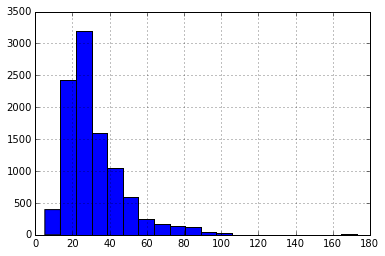

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
f = (data.SalaryNormalized / 1000).hist(bins=20)  # show in thousand dollars

This skew distributed is common for salaries. Money often behaves multiplicative (eg, a 4 _percent_ increase) rather than additive (eg, a \$500 increase).

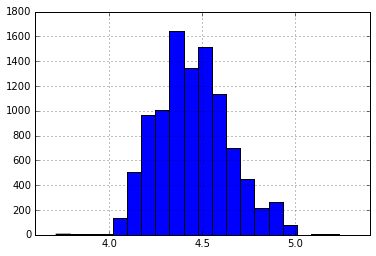

In [4]:
import numpy as np
f = np.log10(data.SalaryNormalized).hist(bins=20)

Almost everyone makes between 4 and 5 figures (eg, between \$10,000 and \$100,000) – and that distribution looks pretty Gaussian.

How many unique entries do we have in the columns?

In [5]:
for col in data:
    print "Column %-20s has %5d unique entries" % (col, data[col].nunique())

Column Id                   has 10000 unique entries
Column Title                has  8273 unique entries
Column FullDescription      has  9940 unique entries
Column LocationRaw          has  2399 unique entries
Column LocationNormalized   has   899 unique entries
Column ContractType         has     2 unique entries
Column ContractTime         has     2 unique entries
Column Company              has  1197 unique entries
Column Category             has    28 unique entries
Column SalaryRaw            has  5780 unique entries
Column SalaryNormalized     has  1023 unique entries
Column SourceName           has    74 unique entries


In [6]:
data.ContractType.value_counts()

full_time    2978
part_time     578
dtype: int64

In [7]:
data.groupby('ContractType').SalaryNormalized.mean().round()

ContractType
full_time    33521
part_time    22759
Name: SalaryNormalized, dtype: float64

We have more FT records than PT records, and FT comes with higher salaries.

In [8]:
data.Category.value_counts()

Healthcare & Nursing Jobs           3149
IT Jobs                             1414
Engineering Jobs                    1152
Accounting & Finance Jobs            606
HR & Recruitment Jobs                578
Hospitality & Catering Jobs          525
Sales Jobs                           426
Teaching Jobs                        342
Customer Services Jobs               257
Other/General Jobs                   236
Admin Jobs                           151
Trade & Construction Jobs            148
Scientific & QA Jobs                 129
Logistics & Warehouse Jobs           110
Manufacturing Jobs                   106
Travel Jobs                          100
Retail Jobs                           93
Legal Jobs                            88
PR, Advertising & Marketing Jobs      88
Consultancy Jobs                      80
Social work Jobs                      53
Property Jobs                         44
Energy, Oil & Gas Jobs                31
Charity & Voluntary Jobs              23
Creative & Desig

Let's checkout the top paying job categories.

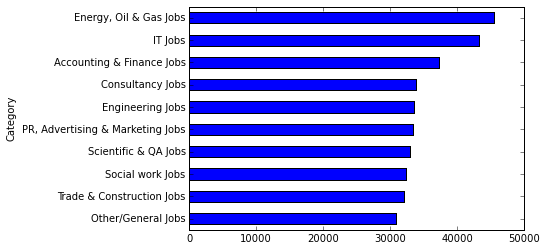

In [9]:
f = data.groupby('Category')[['SalaryNormalized']].mean().sort('SalaryNormalized')[-10:].plot(kind='barh', legend=False)

####Modeling 
- Build a simple linear regression using the available categorical variables.
  - Make sure you use a training and a test set to measure your model accurately
  - Try adding and dropping parameters and see if they improve the model.
  - Try adding interaction effects to improve your model. (Note: beware of the computational overhead)
  - Compare both R-squared and MAE on your test set.

In [10]:
print list(data.columns)

['Id', 'Title', 'FullDescription', 'LocationRaw', 'LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category', 'SalaryRaw', 'SalaryNormalized', 'SourceName']


In [11]:
all_features = ['Id', 'Title', 'FullDescription', 'LocationRaw', 'LocationNormalized',
                'ContractType', 'ContractTime', 'Company', 'Category']

In [12]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from patsy import dmatrices  #, dmatrix, demo_data

Let's try ContractType and Category, since we already saw that those have different average salaries.

In [13]:
Y, X = dmatrices("SalaryNormalized ~ ContractType + Category", data=data, return_type='dataframe')
y = Y.SalaryNormalized
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
print model.score(X_test, y_test)
print mean_absolute_error(y_test, model.predict(X_test))

0.130954652371
9921.15035049


Our predictions are off $10K on average. Not terribly bad, not super great.

Let's try to predict the **log salary**, since we already noticed that money behaves multiplicative.

In [14]:
y = np.log(Y.SalaryNormalized)
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
print model.score(X_test, y_test)
print mean_absolute_error(y_test, model.predict(X_test))
print mean_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))

0.23172142798
0.305961706004
9766.2727832


Indeed a small improvement!
- Indeed, we got a higher $R^2$ score!
- Note that the mean absolute error is now in log space, so we need to convert the values back to dollars.

Let's add more features.

In [15]:
Y, X = dmatrices("SalaryNormalized ~ ContractType + ContractTime + Category", data=data, return_type='dataframe')
y = np.log(Y.SalaryNormalized)
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
print model.score(X_test, y_test)
print mean_absolute_error(y_test, model.predict(X_test))
print mean_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))

0.13393128956
0.299658205025
10423.1862265


This actually seems to do worse.

In [16]:
Y, X = dmatrices("SalaryNormalized ~ LocationNormalized", data=data, return_type='dataframe')
y = np.log(Y.SalaryNormalized)
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
print model.score(X_test, y_test)
print mean_absolute_error(y_test, model.predict(X_test))

-4.05014626816e+25
122748052655.0


This is horrible.

####Imputation
Note that some columns contain empty cells (the `NaN`s), and that `patsy` simply throws those samples out of the dataset. For example, we see that 64% of the contract types are unknown, and 52% of the contract times. In the end, we only have 19% of all training data left.

In [17]:
Y, X = dmatrices("SalaryNormalized ~ ContractType + ContractTime + Category", data=data, return_type='dataframe')
print len(data), len(X)
data.isnull().sum()

10000 1882


Id                       0
Title                    1
FullDescription          0
LocationRaw              0
LocationNormalized       0
ContractType          6444
ContractTime          5263
Company               4049
Category                 0
SalaryRaw                0
SalaryNormalized         0
SourceName               0
dtype: int64

We could replace the empty cells with a placeholder, say `"unknown"`, so that the samples are still in the model. This is called imputation.

In [18]:
Y, X = dmatrices("SalaryNormalized ~ ContractType + Category", data=data.fillna("unknown"), return_type='dataframe')
y = np.log(Y.SalaryNormalized)
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
print model.score(X_test, y_test)
print mean_absolute_error(y_test, model.predict(X_test))
print mean_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))

0.236510327094
0.313472066066
9993.74904121


So far, it doesn't seem to help much.

####Interactions

Try adding interaction effects to improve your model. 

In [19]:
Y, X = dmatrices("SalaryNormalized ~ ContractType * ContractTime + Category", data=data, return_type='dataframe')
y = np.log(Y.SalaryNormalized)
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
print model.score(X_test, y_test)
print mean_absolute_error(y_test, model.predict(X_test))
print mean_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))

0.182568459659
0.294218099005
10511.1737197


Not really a convincing result. Let's try with the imputed data.

In [20]:
Y, X = dmatrices("SalaryNormalized ~ ContractType * ContractTime + Category", 
                 data=data.fillna(""), return_type='dataframe')
y = np.log(Y.SalaryNormalized)
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
print model.score(X_test, y_test)
print mean_absolute_error(y_test, model.predict(X_test))
print mean_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))

0.240402069757
0.307381265775
9721.86932512


Better, indeed! 

For now, it seems that the simplest model **`log SalaryNormalized ~ ContractType + Category`** performs the best.

We'll look at some other features later on.

#### Cross vaildation
- Perform cross-validation to verify that the inclusion (or exclusion) of any variables provides a tangible improvement to the model.

Let's try our earlier features. Note that we put a negatice sign in front of `cross_val_score`, since that function returns _negative_ numbers for the mean absolute error. While this might be confusing, this is to comply with other functions in sklearn that might expect that "a higher score is better", which is indeed the case for many other scoring metrics (such as $R^2$).

In [21]:
from sklearn.cross_validation import cross_val_score

model = LinearRegression()

my_features = [
    "SalaryNormalized ~ ContractType + Category",
    "SalaryNormalized ~ ContractType * ContractTime + Category",
    "SalaryNormalized ~ ContractType * ContractTime * Category"]
    
for features in my_features:
    Y, X = dmatrices(features, data=data.fillna(""), return_type='dataframe')
    y = np.log(Y.SalaryNormalized)
    print "R2 %.2f  MAE %.3f  %s" % \
        (cross_val_score(model, X, y, cv=5, scoring='r2').mean(),
         -cross_val_score(model, X, y, cv=5, scoring='mean_absolute_error').mean(),
         features)

R2 0.13  MAE 0.320  SalaryNormalized ~ ContractType + Category
R2 0.16  MAE 0.315  SalaryNormalized ~ ContractType * ContractTime + Category
R2 -230165058204800210960384.00  MAE 5987097699.793  SalaryNormalized ~ ContractType * ContractTime * Category


Seems like `SalaryNormalized ~ ContractType * ContractTime + Category` performs best: highest $R^2$ and lowest MAE.

####Regularization
- (\*) Use the regularization options available to attempt to improve the model

We're back at using `data` instead of using `data_imputed` since that leads to higher scores. You could check for yourself if that is actually true.

In [22]:
alphas = [1, 10, 100]
my_models = \
    [LinearRegression()] + \
    [Lasso(alpha=alpha) for alpha in alphas] + \
    [Ridge(alpha=alpha) for alpha in alphas]

my_features = [
    "SalaryNormalized ~ ContractType + Category",
    "SalaryNormalized ~ ContractType * ContractTime + Category",
    "SalaryNormalized ~ ContractType * ContractTime * Category"]
    
for model in my_models:
    for features in my_features:
        Y, X = dmatrices(features, data=data, return_type='dataframe')
        y = np.log(Y.SalaryNormalized)
        print "R2 %5.2f  MAE %.3f  %-16s (alpha %4s)  %s" % \
            (cross_val_score(model, X, y, cv=5, scoring='r2').mean(),
             -cross_val_score(model, X, y, cv=5, scoring='mean_absolute_error').mean(),
             model.__class__.__name__, model.__dict__.get('alpha'),
             features)

R2  0.14  MAE 0.315  LinearRegression (alpha None)  SalaryNormalized ~ ContractType + Category
R2  0.07  MAE 0.311  LinearRegression (alpha None)  SalaryNormalized ~ ContractType * ContractTime + Category
R2 -5838384853510604969738240.00  MAE 71368706918.844  LinearRegression (alpha None)  SalaryNormalized ~ ContractType * ContractTime * Category
R2 -0.10  MAE 0.370  Lasso            (alpha    1)  SalaryNormalized ~ ContractType + Category
R2 -0.11  MAE 0.343  Lasso            (alpha    1)  SalaryNormalized ~ ContractType * ContractTime + Category
R2 -0.11  MAE 0.343  Lasso            (alpha    1)  SalaryNormalized ~ ContractType * ContractTime * Category
R2 -0.10  MAE 0.370  Lasso            (alpha   10)  SalaryNormalized ~ ContractType + Category
R2 -0.11  MAE 0.343  Lasso            (alpha   10)  SalaryNormalized ~ ContractType * ContractTime + Category
R2 -0.11  MAE 0.343  Lasso            (alpha   10)  SalaryNormalized ~ ContractType * ContractTime * Category
R2 -0.10  MAE 0.370  

Not very convincing improvements. Let's stick with
- `SalaryNormalized ~ ContractType + Category`
- Ridge and `alpha=1`.
Let's see what the MAE in log space means for the actual price.

In [23]:
model = Ridge(alpha=10)
Y, X = dmatrices("SalaryNormalized ~ ContractType + Category", data=data, return_type='dataframe')
y = np.log(Y.SalaryNormalized)

mae = []
for k in xrange(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    mae.append(np.abs(np.exp(y_pred) - np.exp(y_test)).mean())
cross_validated_mae = np.mean(mae)
print cross_validated_mae

9751.15215333


####Feature creation
- (\*\*) Now let's try adding some text features.  You can create these by hand using `.map` on your dataframe or using scikits-learn and the CountVectorizer

Until now, I kept the columns with a lot of different unique values out of the model, since with 10k samples and 1k entries, you'd otherwise have only 10 samples per dimension on average, which is very little. Especially in combination with other dimesions. It would be nice to somehow aggregate the 1k unique values into a smaller number of similar groups.

In [24]:
data.Title.nunique()

8273

These are too many different values to be useful. 

Let's be creative and find some inferred metrics. Maybe the longer the title, the higher the salary.

In [25]:
data["Title_n_chars"] = data.Title.dropna().map(len)
data["Title_n_words"] = data.Title.dropna().map(lambda x: len(x.split()))

In [26]:
Y, X = dmatrices("SalaryNormalized ~ ContractType + Category + Title_n_words + Title_n_chars", 
                 data=data, return_type='dataframe')
y = np.log(Y.SalaryNormalized)
model = Ridge(alpha=10)
print cross_val_score(model, X, y, cv=5, scoring='r2').mean()
print -cross_val_score(model, X, y, cv=5, scoring='mean_absolute_error').mean()

0.145563709945
0.317015765661


Doesn't seem to help much.

Let's look for common keywords instead.

In [27]:
keywords = [word for title in data.Title.dropna().values for word in title.lower().split()]
print keywords[:20]

['engineering', 'systems', 'analyst', 'stress', 'engineer', 'glasgow', 'modelling', 'and', 'simulation', 'analyst', 'engineering', 'systems', 'analyst', '/', 'mathematical', 'modeller', 'pioneer,', 'miser', 'engineering', 'systems']


Let's clean up the set and look for the most common keywords.

In [28]:
print list(np.sort(keywords))[:10]  # sorting alphabetically quickly shows some ugly keywords
print list(np.sort(keywords))[-10:]  # sorting alphabetically quickly shows some ugly keywords

['$****', '$****', '$****', '$****', '$****', '&', '&', '&', '&', '&']
['\xe2\x80\x93', '\xe2\x80\x93', '\xe2\x80\x93', '\xe2\x80\x93', '\xe2\x80\x93financial', '\xe2\x80\x93purchasing/supply', '\xe2\x82\xac****k', '\xe2\x82\xac****k', '\xe2\x82\xac\xe2\x80\x9c', '\xef\xbb\xbfcall']


In [29]:
keywords = [str(word.decode('ascii', 'ignore')) for word in keywords]  # remove weird unicode characters (like euro sign)

# replace ugly characters by white spaces and split words again
ugly_chars = list("$*()/?'\"[]`_,%&1234567890")  
for c in ugly_chars:
    keywords = [word for ugly_word in keywords for word in ugly_word.split(c)]

# Remove very small words: 'and', single characters, etc.
keywords = [word for word in keywords if len(word) >= 4]  

In [30]:
top = 10  # And look for most common words
top_keywords = list(pd.Series(keywords).value_counts().head(top).index)
print top_keywords

['manager', 'nurse', 'engineer', 'senior', 'home', 'care', 'sales', 'support', 'developer', 'worker']


We can add features for each of these words.

In [31]:
for keyword in top_keywords:
    data[keyword] = data.Title.map(lambda x: x.find(keyword) > -1 if isinstance(x, basestring) else None)

In [32]:
pd.options.display.max_columns = 35
data.head(1)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Title_n_chars,Title_n_words,manager,nurse,engineer,senior,home,care,sales,support,developer,worker
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,27,3,False,False,False,False,False,False,False,False,False,False


In [33]:
features = "SalaryNormalized ~ ContractType + Category + " + " + ".join(top_keywords)
print features

SalaryNormalized ~ ContractType + Category + manager + nurse + engineer + senior + home + care + sales + support + developer + worker


In [34]:
Y, X = dmatrices(features, data=data.fillna(""), return_type='dataframe')
y = np.log(Y.SalaryNormalized)
print -cross_val_score(Ridge(alpha=10), X, y, cv=5, scoring='mean_absolute_error').mean()

0.319108382325


Bummer! This is not even better than we already had!

More on this later.

####Location tree

- (\*\*) Merge `Location_Tree.csv` on to your dataset - do any features from here to improve performance. You'll need to **convert this file** before you can effectively use it. You might want to try using shell commands. For example, this command will change the `~` to a comma and remove the quote marks. Note: do **not** redirect this to the same file, since using `>` on a file that exists will wipe it.
    ```sh
    cat Location_Tree.csv | sed 's/~/,/g' | sed 's/"//g' > Location_Tree2.csv
    ```

In [35]:
filename = "/Users/ruben/Downloads/Location_Tree.csv"
with open(filename) as f:
    # format is in "UK~London~East London~Bethnal Green"
    lines = [line.strip()[1:-1].split("~") for line in f]
df = pd.DataFrame(lines)
df.head(3)

,0,1,2,3,4,5,6
0,UK,London,East London,Mile End,None,None,None
1,UK,London,East London,Shadwell,None,None,None
2,UK,London,East London,Spitalfields,None,None,None


In [36]:
region = {}
for from_col in xrange(7):
    for to_col in xrange(0, from_col):
        if to_col not in region:
            region[to_col] = {}
        region[to_col].update(dict(df[[from_col, to_col]].dropna().groupby([from_col, to_col]).groups.keys()))

In [37]:
town = 'Monalla'
print town, ":", ", ".join(region[i][town] for i in range(5))
df[df[5] == town]

Monalla : UK, Northern Ireland, Fermanagh, Enniskillen, Ballinamallard


,0,1,2,3,4,5,6
11877,UK,Northern Ireland,Fermanagh,Enniskillen,Ballinamallard,Monalla,None


In [38]:
data['Country'] = data.LocationNormalized.map(region[0])
data['County'] = data.LocationNormalized.map(region[1])
data['City'] = data.LocationNormalized.map(region[2])
data['Town'] = data.LocationNormalized.map(region[3])
data['Hood'] = data.LocationNormalized.map(region[4])

In [39]:
for col in ['Country', 'County', 'City', 'Town', 'Hood']:
    print col, data[col].nunique()

Country 1
County 13
City 111
Town 158
Hood 30


- Country is only UK, so that doesn't help. But we could use the other ones. 
- We definitely want to include the empty cells now, since throwing them away would leave us with only 36 samples.

In [40]:
features = "SalaryNormalized ~ ContractType + Category + " + \
    " + ".join(top_keywords) + \
    " + County + City + Town + Hood"
print features    
Y, X = dmatrices(features, data=data.fillna(""), return_type='dataframe')
y = np.log(Y.SalaryNormalized)
print -cross_val_score(Ridge(alpha=10), X, y, cv=5, scoring='mean_absolute_error').mean()

SalaryNormalized ~ ContractType + Category + manager + nurse + engineer + senior + home + care + sales + support + developer + worker + County + City + Town + Hood
0.306050419643


If it is an improvement, it's a very small one..

In [41]:
print "Last MAE:", cross_validated_mae
mae = []
for k in xrange(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    mae.append(np.abs(np.exp(y_pred) - np.exp(y_test)).mean())
print "New  MAE:", np.mean(mae)

Last MAE: 9751.15215333
New  MAE: 9514.28835517


A $300+ improvement. Could be worse!

#### More text features

Earlier we looked at the top keywords in the `Title` column. We could do the same for the text in the `FullDescription` column. We'll use a standard package for this.





In [42]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(1,2), max_features = 1000)  #, min_df=3, max_df=.97
description_features = cv.fit_transform(data.FullDescription).todense()

CPU times: user 5.74 s, sys: 202 ms, total: 5.94 s
Wall time: 5.94 s


In [43]:
Y, X = dmatrices(features, data=data.fillna(0), return_type='dataframe')
X = np.hstack((X, description_features))  # use both feature sets
y = np.log(Y.SalaryNormalized)
print -cross_val_score(Ridge(alpha=10), X, y, cv=5, scoring='mean_absolute_error').mean()

0.253244747231


THAT's more like it! Let's check what this MAE is in $$.

In [44]:
%%time
model = Ridge(alpha=10)
mae = []
for k in xrange(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    mae.append(np.abs(np.exp(y_pred) - np.exp(y_test)).mean())
print np.mean(mae)

7722.72513332
CPU times: user 28.3 s, sys: 1.31 s, total: 29.6 s
Wall time: 8.36 s


Not bad: our model if $7700 off on average. Note that this is still better than if we would model the salary directly instead of the log salary.

In [45]:
-cross_val_score(Ridge(alpha=10), X, Y.SalaryNormalized, cv=5, scoring='mean_absolute_error').mean()

8986.0687851635448

We stop here, but you could try to further improve your model:
- Try different options for `CountVectorizer`, such as `min_df`, `max_df`, `max_features`, etc.
- Try different `alpha`s for both `Lasso` and `Ridge` again, for your new feature set.

###Final solution
Let's make our predictions on the test set.

In [46]:
test = pd.read_csv("/Users/ruben/Downloads/test.csv")

Add additional features: keywords and locations

In [47]:
for keyword in top_keywords:
    test[keyword] = test.Title.map(lambda x: x.find(keyword) > -1 if isinstance(x, basestring) else None)
    
# Only add these location features if they were in the training set
places = set(data[['Country', 'County', 'Town', 'Hood']].values.reshape(len(data) * 4))
region = {no: {key: region[no][key] for key in places.intersection(region)} for no in region}
test['County'] = data.LocationNormalized.map(region[1])
test['City'] = data.LocationNormalized.map(region[2])
test['Town'] = data.LocationNormalized.map(region[3])
test['Hood'] = data.LocationNormalized.map(region[4])    

Design model on entire dataset, so that columns and coefficients will be aligned.

In [48]:
from patsy import dmatrix
all_data = pd.concat([data, test])
features = "SalaryNormalized ~ ContractType + Category + County + City + Town + Hood + " + " + ".join(top_keywords)
Y, X = dmatrices(features, data=all_data.fillna(0), return_type='dataframe')
description_features = cv.fit_transform(all_data.FullDescription).todense()
X = np.hstack((X, description_features))

In [49]:
X_train, y_train = X[:len(data)], np.log(Y.SalaryNormalized[:len(data)])
X_test = X[len(data):]

In [50]:
model = Ridge(alpha=10).fit(X_train, y_train)
y_pred = np.exp(model.predict(X_test))  # predict salaries in real dollars (not in log space)
predictions = pd.DataFrame(dict(Id=test.Id, Salary=y_pred.round()))
predictions.to_csv("/Users/ruben/Downloads/HW2 Linear Regression/ruben_naeff_predictions.csv", index=False)

Done!

Let's check just to be sure if our predicted salaries are not way off.

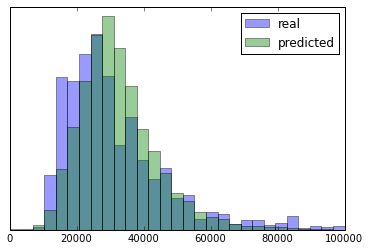

In [51]:
bins = np.linspace(0, 100000, 30)
f = plt.hist(data.SalaryNormalized, bins=bins, alpha=.4, normed=True, label='real')
f = plt.hist(y_pred, bins=bins, alpha=.4, normed=True, label='predicted')
f = plt.legend(), plt.yticks([])

The predictions seem a little too much concentrated around the center, and a little higher on average.

####Big data
- (\*\*) If you were just loading the `train.csv` file so far, try loading one of the large datasets.  Does the larger dataset improve performance on the held-out test set?  If possible, try loading an even larger file.

In [52]:
# Left as a playful exercise to the reader

###Checking your answers

The real salaries of the dataset can be downloaded from the following link.

- [test-solution.csv](http://gadatascience.com/datasets/adzuna_salary_prediction/test-solution.csv)

This file has the same data as the `test.csv`, but has the final two columns added back. 

Let's check our answers with it.

In [53]:
solution = pd.read_csv("/Users/ruben/Downloads/test-solution.csv", index_col=0)
predictions.index = predictions.Id

In [54]:
np.abs(predictions.Salary - solution.SalaryNormalized).mean()

11017.8128

Ough! A mean absolute error of $11k, much more than we thought. Not shown here, but if we would have modeled real salaries directly instead of log salaries, we would have had an even bigger error. 

It could very well be that the test set consisted of different jobs than our training set, with a slightly different source and category distribution.

Let's check the distributions.

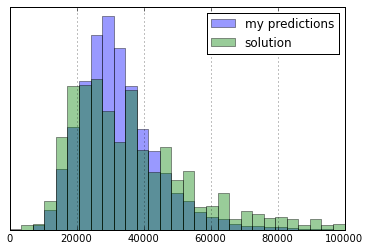

In [55]:
f = predictions.Salary.hist(bins=bins, alpha=.4, normed=True, label='my predictions')
f = solution.SalaryNormalized.hist(bins=bins, alpha=.4, normed=True, label='solution')
f = plt.legend(), plt.yticks([])

Indeed, my predictions were a bit too concentrated around the center.